# LING 380 Project Naive Bayes Model

### Import Libraries

In [1]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import resample

### Clean .txt Files and Compile to One DataFrame

In [2]:
def preprocess_text(content):
    content = re.sub(r"<[^>]+>", "", content)
    content = re.sub(r"[^\w\s]", "", content)
    content = re.sub(r"\s+", " ", content)
    content = content.lower()
    return content

def make_df(file_path, file_name):
    with open(file_path, 'r', encoding='utf-8') as file:
        raw_text = file.read()

    sections = re.split(r"(##\d+)", raw_text)
    
    processed_data = []
    
    for i in range(1, len(sections), 2):
        section_id = sections[i].strip()
        content = sections[i + 1].strip() if i + 1 < len(sections) else ""

        content = preprocess_text(content)
        
        processed_data.append({"section_id": section_id, "content": content, "file_name": file_name})
    
    return pd.DataFrame(processed_data)

def process_and_combine(input_folder, output_file):
    all_data = []
    
    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        
        if os.path.isfile(file_path) and file_name.endswith(".txt"):
            print(f"Processing file: {file_name}")
            processed_df = make_df(file_path, file_name)
            all_data.append(processed_df)
    
    combined_df = pd.concat(all_data, ignore_index=True)

    combined_df.to_csv(output_file, index=False)
    print(f"All files processed and saved to: {output_file}")

#process_and_combine("/Users/michaeltoben/Downloads/text", "/Users/michaeltoben/Downloads/text")

### Find Best Model

In [3]:
train_data = pd.read_csv("/Users/michaeltoben/Downloads/dialect-classifier/LING380_project_data.csv")
train_data['file_name'] = train_data['file_name'].str.extract(r'w_([a-z]{2})_')[0].str.upper()
allowed_codes = train_data['file_name'].unique().tolist()
train_data = train_data[train_data['file_name'].isin(allowed_codes)]


avg_accuracies = []

for i in np.arange(1, 4):
    model_accuracies = []
    print(f"Processing n-grams ranging from 1 to {i}...")

    for j in np.arange(1, 21):
        if j % 5 == 0:
            print(f"Iteration {j} for n-grams ranging from 1 to {i}")

        vectorizer = CountVectorizer(ngram_range=(1, i), max_features=10000)
        X = vectorizer.fit_transform(train_data['content'])

        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(train_data['file_name'])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

        class_counts = np.bincount(y_train)
        class_priors = class_counts / np.sum(class_counts)

        model = MultinomialNB(class_prior=class_priors)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        model_accuracies.append(np.mean(y_pred == y_test))

    avg_accuracies.append(np.mean(model_accuracies))
    print(f"Average accuracy for n-grams ranging from 1 to {i}: {np.mean(model_accuracies):.4f}")

best_index = np.argmax(avg_accuracies) + 1
print(f"Best accuracy achieved for model using n-grams ranging from 1 to {(best_index)}")
print(f"Accuracy: {np.round(np.max(avg_accuracies), 3)}")
    

Processing n-grams ranging from 1 to 1...
Iteration 5 for n-grams ranging from 1 to 1
Iteration 10 for n-grams ranging from 1 to 1
Iteration 15 for n-grams ranging from 1 to 1
Iteration 20 for n-grams ranging from 1 to 1
Average accuracy for n-grams ranging from 1 to 1: 0.2962
Processing n-grams ranging from 1 to 2...
Iteration 5 for n-grams ranging from 1 to 2
Iteration 10 for n-grams ranging from 1 to 2
Iteration 15 for n-grams ranging from 1 to 2
Iteration 20 for n-grams ranging from 1 to 2
Average accuracy for n-grams ranging from 1 to 2: 0.2909
Processing n-grams ranging from 1 to 3...
Iteration 5 for n-grams ranging from 1 to 3
Iteration 10 for n-grams ranging from 1 to 3
Iteration 15 for n-grams ranging from 1 to 3
Iteration 20 for n-grams ranging from 1 to 3
Average accuracy for n-grams ranging from 1 to 3: 0.2759
Best accuracy achieved for model using n-grams ranging from 1 to 1
Accuracy: 0.296


### Retrain Best Model with Validation Set

In [54]:
vectorizer = CountVectorizer(ngram_range=(1, best_index), max_features=10000)
X = vectorizer.fit_transform(train_data['content'])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_data['file_name'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

class_counts = np.bincount(y_train)
class_priors = class_counts / np.sum(class_counts)

model = MultinomialNB(class_prior=class_priors)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("Report for best model with validation data:")
print(report)

Report for best model with validation data:
              precision    recall  f1-score   support

          AU       0.17      0.27      0.21        26
          BD       0.00      0.00      0.00         7
          CA       0.15      0.09      0.11        23
          GB       0.40      0.44      0.42        68
          GH       0.40      0.29      0.33         7
          HK       0.20      0.14      0.17         7
          IE       0.22      0.28      0.24        18
          IN       0.33      0.18      0.23        17
          JM       0.00      0.00      0.00         7
          KE       0.25      0.14      0.18         7
          LK       0.25      0.25      0.25         8
          MY       0.67      0.29      0.40         7
          NG       0.09      0.14      0.11         7
          NZ       0.18      0.21      0.19        14
          PH       0.00      0.00      0.00         8
          PK       0.83      0.56      0.67         9
          SG       0.33      0.50    

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Visualize Performance on Validation Set Using Confusion Matrix

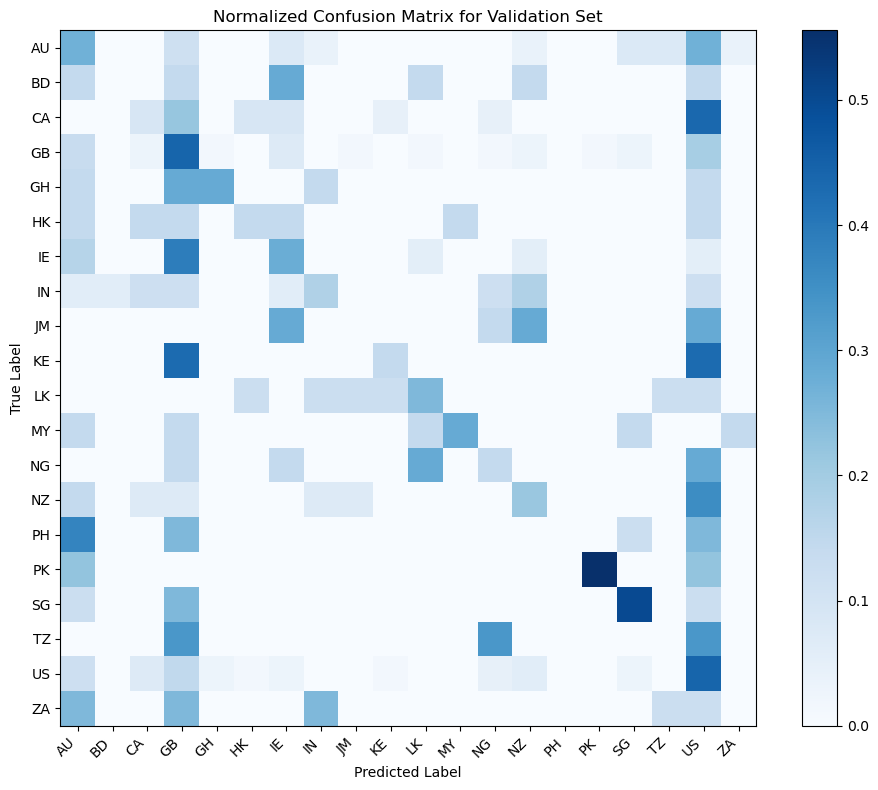

In [55]:
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

class_names = label_encoder.classes_
plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

'''thresh = cm_normalized.max() / 2.0
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(
            j, i, f"{cm_normalized[i, j]:.2f}",
            horizontalalignment="center",
            color="white" if cm_normalized[i, j] > thresh else "black"
        )
'''
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix for Validation Set')
plt.tight_layout()
plt.show()

### Test on Now Data

In [56]:
now_data = pd.read_csv("https://raw.githubusercontent.com/imjnnanna/dialect-classifier/refs/heads/main/testing/now.csv")
now_data['text'] = now_data['text'].apply(preprocess_text)
now_data = now_data[now_data['country'].isin(allowed_codes)]

X_test = vectorizer.transform(now_data['text'])
y_test = label_encoder.transform(now_data['country'])

y_test_sample = resample(
    y_test, replace=False, n_samples=int(0.5 * len(y_test)), random_state=42
)

sample_class_counts = np.bincount(y_test_sample)
sample_class_priors = sample_class_counts / np.sum(sample_class_counts)

model = MultinomialNB(class_prior=sample_class_priors)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report_now = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("Report for best model with now data:")
print(report_now)


Report for best model with now data:
              precision    recall  f1-score   support

          AU       0.15      0.20      0.17       147
          BD       0.09      0.15      0.12        20
          CA       0.28      0.17      0.21       351
          GB       0.22      0.46      0.29       385
          GH       0.13      0.11      0.12        56
          HK       0.00      0.00      0.00         5
          IE       0.23      0.15      0.18       267
          IN       0.37      0.11      0.17       380
          JM       0.00      0.00      0.00        15
          KE       0.05      0.03      0.04        32
          LK       0.05      0.25      0.08        16
          MY       0.09      0.01      0.02        71
          NG       0.23      0.09      0.12       129
          NZ       0.11      0.03      0.05       120
          PH       0.00      0.00      0.00       111
          PK       0.25      0.01      0.02        77
          SG       0.07      0.02      0.03 

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Visualize Performance on Now Data Using Confusion Matrix

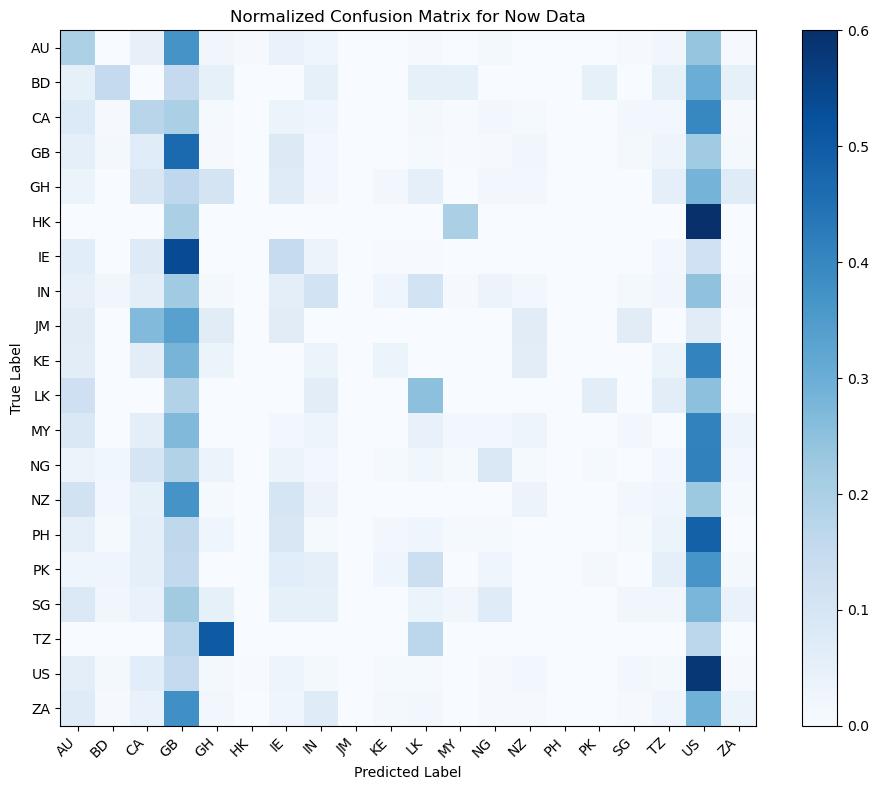

In [57]:
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

class_names = label_encoder.classes_
plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

'''thresh = cm_normalized.max() / 2.0
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(
            j, i, f"{cm_normalized[i, j]:.2f}",
            horizontalalignment="center",
            color="white" if cm_normalized[i, j] > thresh else "black"
        )
'''
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix for Now Data')
plt.tight_layout()
plt.show()

### Test on Covid Data

In [58]:
covid_data = pd.read_csv("https://raw.githubusercontent.com/imjnnanna/dialect-classifier/refs/heads/main/testing/covid.csv")
covid_data['text'] = covid_data['text'].apply(preprocess_text)
covid_data = covid_data[covid_data['country'].isin(allowed_codes)]

X_test = vectorizer.transform(covid_data['text'])
y_test = label_encoder.transform(covid_data['country'])

y_test_sample = resample(
    y_test, replace=False, n_samples=int(0.5 * len(y_test)), random_state=42
)

sample_class_counts = np.bincount(y_test_sample)
sample_class_priors = sample_class_counts / np.sum(sample_class_counts)

model = MultinomialNB(class_prior=sample_class_priors)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report_covid = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("Report for best model with Covid data:")
print(report_covid)

Report for best model with Covid data:
              precision    recall  f1-score   support

          AU       0.16      0.27      0.20       211
          BD       0.13      0.24      0.17        34
          CA       0.29      0.08      0.13       261
          GB       0.20      0.45      0.28       356
          GH       0.09      0.09      0.09        34
          HK       0.22      0.07      0.11        29
          IE       0.25      0.24      0.25       179
          IN       0.38      0.03      0.06       319
          JM       0.00      0.00      0.00        14
          KE       0.03      0.01      0.02        74
          LK       0.21      0.42      0.28        31
          MY       0.50      0.04      0.08        93
          NG       0.33      0.09      0.14       164
          NZ       0.21      0.07      0.11       110
          PH       0.00      0.00      0.00        96
          PK       0.00      0.00      0.00        60
          SG       0.00      0.00      0.0

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Visualize Performance on Covid Data Using Confusion Matrix

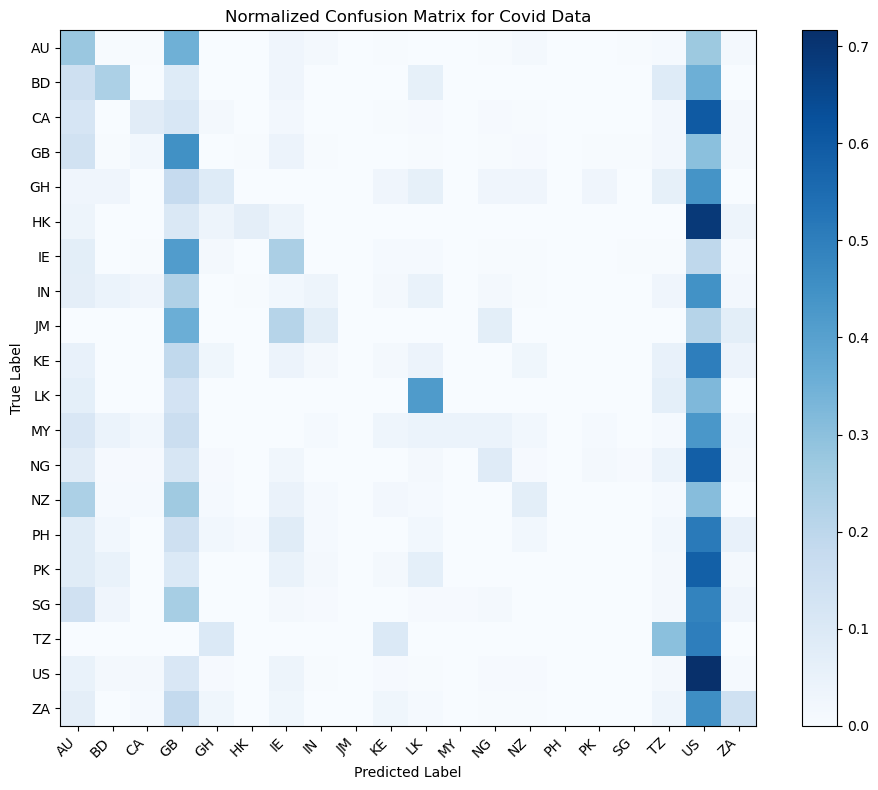

In [59]:
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

class_names = label_encoder.classes_
plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

'''thresh = cm_normalized.max() / 2.0
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(
            j, i, f"{cm_normalized[i, j]:.2f}",
            horizontalalignment="center",
            color="white" if cm_normalized[i, j] > thresh else "black"
        )
'''
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix for Covid Data')
plt.tight_layout()
plt.show()

### Test on Media Data

In [49]:
media_data = pd.read_csv("https://raw.githubusercontent.com/imjnnanna/dialect-classifier/refs/heads/main/testing/media.csv")
media_data['text'] = media_data['text'].apply(preprocess_text)
media_data = media_data[media_data['country'].isin(allowed_codes)]

X_test = vectorizer.transform(media_data['text'])
y_test = label_encoder.transform(media_data['country'])

y_test_sample = resample(
    y_test, replace=False, n_samples=int(1 * len(y_test)), random_state=42
)

sample_class_counts = np.bincount(y_test_sample)
sample_class_priors = sample_class_counts / np.sum(sample_class_counts)
sample_class_priors = sample_class_priors.tolist() + [0]*14

model = MultinomialNB(class_prior=sample_class_priors)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report_media = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("Report for best model with Covid data:")
print(report_media)

Report for best model with Covid data:
              precision    recall  f1-score   support

          AU       0.02      1.00      0.04        11
          CA       0.00      0.00      0.00        32
          GB       0.07      0.01      0.02        90
          IE       0.00      0.00      0.00         1
          PH       0.00      0.00      0.00         1
          US       0.00      0.00      0.00       494

    accuracy                           0.02       629
   macro avg       0.01      0.17      0.01       629
weighted avg       0.01      0.02      0.00       629



/opt/anaconda3/lib/python3.11/site-packages/sklearn/naive_bayes.py:596: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = np.log(class_prior)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samp

### Visualize Performance on Media Data Using Confusion Matrix

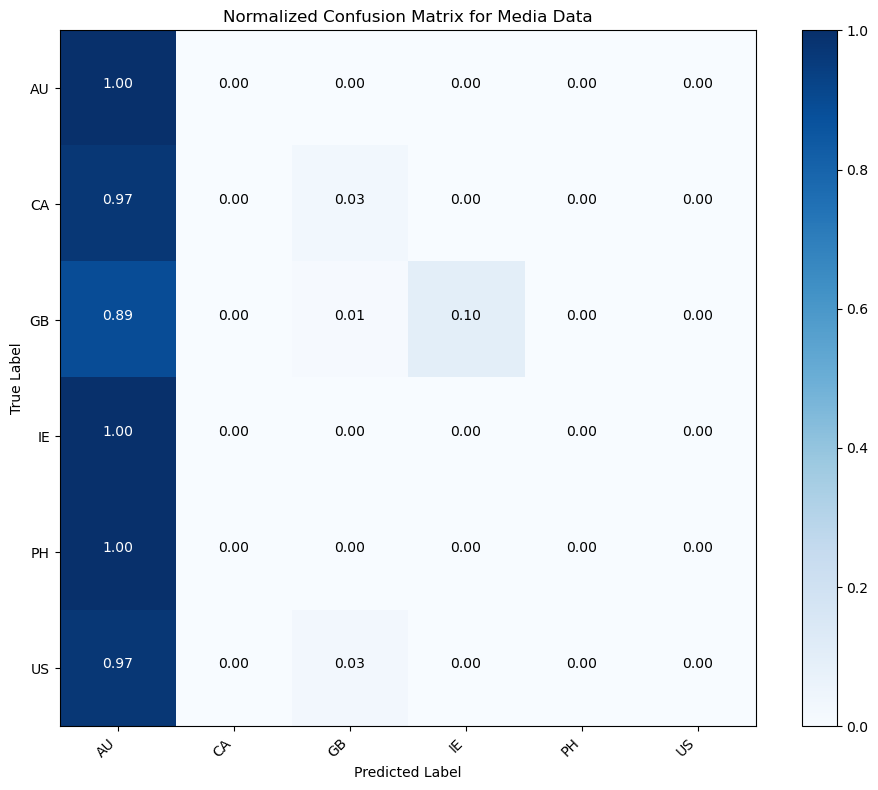

In [21]:
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

class_names = label_encoder.classes_
plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

thresh = cm_normalized.max() / 2.0
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(
            j, i, f"{cm_normalized[i, j]:.2f}",
            horizontalalignment="center",
            color="white" if cm_normalized[i, j] > thresh else "black"
        )

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix for Media Data')
plt.tight_layout()
plt.show()